## Frequency Analysis

Generating a complex pattern (distribution) from a single value can be done with dense layers, conv layer and recurrent layers. Autoencoders and Variational Autoencoders can easily be trained to decode a small latent-space vector into a complex image or waveform.

This document investigates what kinds of networks are best suited to extract the required information needed to re-generate an input waveform.

Ideally, we want a network that performs a component analysis of an input sample, and outputs the frequencies of the sinewaves that it consists of.

In [1]:
from __future__ import division

import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
context = data.init()
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [4]:
n = 1000
min_f = 0
max_f = 4
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=1,
    d_phase=False,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  ffs
 |  [[[ 3.31630099]]

 [[ 0.82133991]]

 [[ 3.03381994]]

 [[ 3.31682256]]

 [[ 2.09443688]]

 [[ 0.25184411]]

 [[ 1.83837897]]

 [[ 3.88773812]]

 [[ 0.52680354]]

 [[ 0.93272385]]

 [[ 1.04265975]]

 [[ 3.97765637]]

 [[ 3.05412603]]

 [[ 2.34535827]]

 [[ 0.71175962]]

 [[ 3.80252895]]

 [[ 2.11049251]]

 [[ 0.50067827]]

 [[ 0.55230849]]

 [[ 2.99239943]]

 [[ 2.68931664]]

 [[ 0.48234786]]

 [[ 0.60433078]]

 [[ 3.85569785]]

 [[ 0.18570307]]

 [[ 3.18814315]]

 [[ 1.73978058]]

 [[ 1.41465696]]

 [[ 3.79440842]]

 [[ 2.50080064]]

 [[ 0.36437124]]

 [[ 2.35405014]]

 [[ 3.91679329]]

 [[ 3.48485113]]

 [[ 1.74298578]]

 [[ 3.65318901]]

 [[ 1.98385984]]

 [[ 2.64935383]]

 [[ 2.76975068]]

 [[ 0.18115045]]

 [[ 2.7341833 ]]

 [[ 1.05918057]]

 [[ 2.33950395]]

 [[ 0.97910031]]

 [[ 2.9928369 ]]

 [[ 3.24537446]]

 [[ 0.2834726 ]]

 [[ 1.89106873]]

 [[ 2.18265083]]

 [[ 0.49197764]]

 [[ 3.66544075]]

 [[ 3.20918873]]

 [[ 1.88336101]]

 [[ 2.98714173]]

 [[ 1

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 1)


In [5]:
params.shape # n, n_channels, n_polyrythms

(1000, 1, 1)

In [6]:
x_train.shape

(1000, 100, 1, 1)

In [7]:
# train test split
m = int(x_train.shape[0] * 0.9)

(array([ 2.,  2.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,  1.]),
 array([ 0.25184411,  0.61543352,  0.97902292,  1.34261232,  1.70620172,
         2.06979112,  2.43338052,  2.79696992,  3.16055932,  3.52414872,
         3.88773812]),
 <a list of 10 Patch objects>)

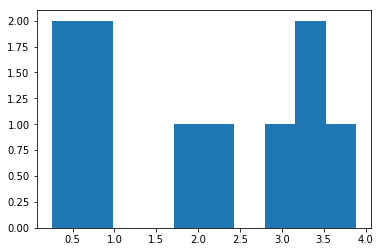

In [8]:
plt.hist(params[:10,0,0])

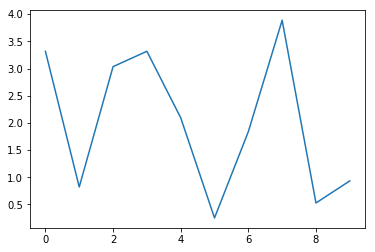

In [9]:
plt.plot(params[:10,0,0])

In [10]:
# range_ = (max_f - min_f)
range_ = max_f + 1 # extra margin = 1
y_train = params[:,0,0] / range_
y_train.shape

(1000,)

In [11]:
x_train.shape

(1000, 100, 1, 1)

In [12]:
x_test = x_train[m:]
x_train = x_train[:m]
y_test = y_train[m:]
y_train = y_train[:m]

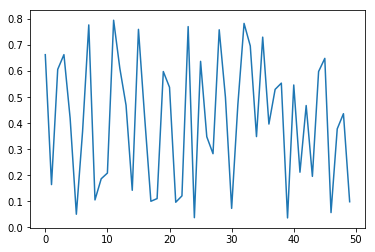

In [13]:
plt.plot(y_train[:50])

m (30, 1)


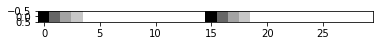

m (30, 1)


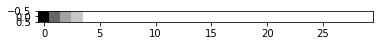

[ 0.6632602   0.16426798]


In [14]:
i = 0
plot.single(x_train[i,:30,0])
plot.single(x_train[i+1,:30,0])
print(y_train[i:i+2])

Make sure all frequencies fall inside the window

m (30, 1)


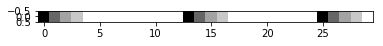

m (30, 1)


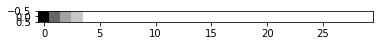

0.798964913572 0.00292342340122


In [15]:
i = y_train.argmax()
j = y_train.argmin()
plot.single(x_train[i,:30,0])
plot.single(x_train[j,:30,0])
print(y_train[i], y_train[j])

In [16]:
input_shape = x_train[0].shape
input_shape

(100, 1, 1)

In [34]:
timesteps, notes, channels = input_shape

encoder_input = Input(shape=(timesteps, notes, channels))
x = encoder_input

x = Reshape((timesteps, notes))(x)
# x = Reshape((timesteps, notes,1,1))(x)
# x = SimpleRNN(1)(x)
x = SimpleRNN(3)(x)
# x = ConvLSTM2D(3, kernel_size=(1,1))(x)
# x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

encoder_output = x

encoder_model = Model(encoder_input, encoder_output, name='encoder-')
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 1, 1)         0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 3)                 15        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [35]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta
encoder_model.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','binary_crossentropy'])

In [36]:
phase_mod = 0.1
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [37]:
batch_size = 100
epochs = 90

In [38]:
data_augmentation = False
# data_augmentation = True

callbacks = []
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

if not data_augmentation:
    print('Not using data augmentation.')
#     history = ae.fit(x_train, epochs=epochs, validation_data=(x_test, None))
    history = encoder_model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = encoder_model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        workers=4)

Not using data augmentation.
Train on 900 samples, validate on 100 samples
Epoch 1/90
900/900 [==============================] - 1s 647us/step - loss: 0.0428 - acc: 0.0000e+00 - mean_absolute_error: 0.1762 - binary_crossentropy: 0.6563 - val_loss: 0.0334 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1550 - val_binary_crossentropy: 0.6329
Epoch 2/90
900/900 [==============================] - 0s 438us/step - loss: 0.0289 - acc: 0.0000e+00 - mean_absolute_error: 0.1433 - binary_crossentropy: 0.6276 - val_loss: 0.0237 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1244 - val_binary_crossentropy: 0.6125
Epoch 3/90
900/900 [==============================] - 0s 454us/step - loss: 0.0231 - acc: 0.0000e+00 - mean_absolute_error: 0.1259 - binary_crossentropy: 0.6152 - val_loss: 0.0196 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1125 - val_binary_crossentropy: 0.6036
Epoch 4/90
900/900 [==============================] - 0s 437us/step - loss: 0.0197 - acc: 0.0000e+00 - mean_absolut

Epoch 31/90
900/900 [==============================] - 0s 441us/step - loss: 0.0115 - acc: 0.0000e+00 - mean_absolute_error: 0.0887 - binary_crossentropy: 0.5887 - val_loss: 0.0116 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0899 - val_binary_crossentropy: 0.5841
Epoch 32/90
900/900 [==============================] - 0s 444us/step - loss: 0.0131 - acc: 0.0000e+00 - mean_absolute_error: 0.0958 - binary_crossentropy: 0.5918 - val_loss: 0.0117 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0914 - val_binary_crossentropy: 0.5846
Epoch 33/90
900/900 [==============================] - 0s 435us/step - loss: 0.0118 - acc: 0.0000e+00 - mean_absolute_error: 0.0903 - binary_crossentropy: 0.5892 - val_loss: 0.0114 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.0890 - val_binary_crossentropy: 0.5836
Epoch 34/90
900/900 [==============================] - 0s 429us/step - loss: 0.0117 - acc: 0.0000e+00 - mean_absolute_error: 0.0894 - binary_crossentropy: 0.5888 - val_loss: 0.0113 - val_

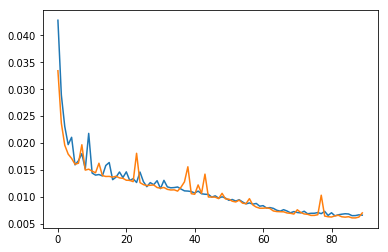

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

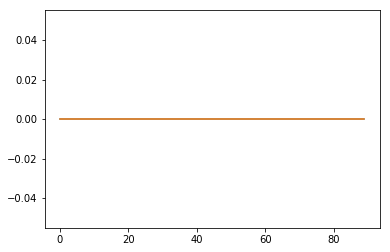

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

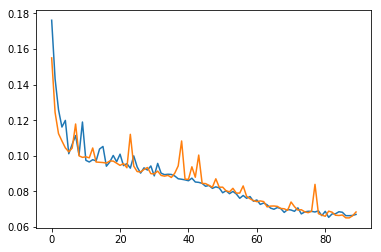

In [41]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [42]:
i = 1
y_train[i]

0.16426798112508675

In [43]:
encoder_model.predict(x_train[:10])[i]

array([ 0.16691206], dtype=float32)

In [44]:
i = y_train.argmin()
y_train[i:i+2]

array([ 0.00292342,  0.41293571])

In [45]:
encoder_model.predict([x_train[i:i+2]])

array([[ 0.15453707],
       [ 0.32225311]], dtype=float32)

## Decoder
mapping: f -> sin(f)

In [46]:
from keras.utils.generic_utils import get_custom_objects

In [47]:
# saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
def saw(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
    
#     return K.tf.where(x < 1, x, K.zeros_like(x))
    return K.tf.where(x < 1, x, x - 1)

def sawDescending(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
#     return K.tf.where(x > 0, x, K.ones_like(x))
    return K.tf.where(x > 0, x, x + 1)

get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# make sure to import this function when loading this model in another module

In [48]:
# # saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
# def saw(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 1, x, x - 1)

# def sawDescending(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 0, K.ones_like(x), x)

# get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# # make sure to import this function when loading this model in another module

In [255]:
decoder_input = Input(shape=(notes,))
x = decoder_input

unroll = False

ratio = 0.1
sub_t = int(timesteps * ratio)
super_t = int(timesteps/ sub_t)

# a = ELU(alpha=0.5)
# ThresholdedReLU
# PReLU
# ELU
# LeakyRelu

# x1 = starting value
# x2 :: [decay1, decay2, decay3]
# end of sequence = decay3 * (decay2 * (decay1 * x1))
# full sequence = [decay1 * x1, decay2(decay1 * x1), etc... ]

# x1 might have abias of zero
# TODO x1 ** 0.5
# x2 might disregard its input
# TODO check if x2 can have an offset bias

# decay is non-linear?
# decay = 1/f

width = 2
dims = notes * channels * width

x1 = x
x1 = Dense(dims, activation='relu')(x1) # phase (linear)
x1 = RepeatVector(1)(x1)

x2 = x
x2 = Dense(dims, activation='relu')(x2) # e.g decay: 0.5 * decay, 0.5 * decay * decay
x2 = Dense(dims, activation='relu')(x2)
x2 = RepeatVector(timesteps)(x2)

# SimpleRNN returns 2 states, LSTM returns 3 states
_, state = SimpleRNN(dims, return_state=True)(x1)
rnn = SimpleRNN(dims, activation='sawDescending', return_sequences=True, unroll=unroll)
# rnn = SimpleRNN(notes, return_sequences=True)
# x = rnn(x2, initial_state=x1) # shape error
x = rnn(x2, initial_state=state)

# Final layer(s)
filters = 6
kernel_size = (1,2) # (2,1)

# Conv Transpose
# x = Reshape((timesteps, notes, width))(x)
# x = Conv2DTranspose(filters, kernel_size, strides=(1,1), activation='relu', padding='same')(x)
# x = Conv2D(1, kernel_size, strides=(1,1), activation='sigmoid', padding='same')(x)

x = Conv1D(1, kernel_size=1, strides=1, activation='sigmoid', padding='same')(x)
# x = Flatten()(x)
# x = Dense(np.prod(input_shape))(x)
# x = Activation('sigmoid')(x)
x = Reshape(input_shape)(x)

decoder_output = x

decoder_model = Model(decoder_input, decoder_output, name='decoder-')
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_194 (Dense)               (None, 2)            4           input_63[0][0]                   
__________________________________________________________________________________________________
dense_193 (Dense)               (None, 2)            4           input_63[0][0]                   
__________________________________________________________________________________________________
dense_195 (Dense)               (None, 2)            6           dense_194[0][0]                  
__________________________________________________________________________________________________
repeat_vec

In [256]:
ae = Model(decoder_input, encoder_model(decoder_model(decoder_input)))
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
decoder- (Model)             (None, 100, 1, 1)         37        
_________________________________________________________________
encoder- (Model)             (None, 1)                 19        
Total params: 56
Trainable params: 37
Non-trainable params: 19
_________________________________________________________________


In [257]:
encoder_model.trainable = False

In [258]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta hinge
ae.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','mse'])

In [259]:
batch_size = 100
epochs = 60

In [260]:
j = -1
history = ae.fit(y_train[:j], y_train[:j], 
    epochs=epochs, batch_size=batch_size, 
    validation_data=(y_test, y_test))

Train on 899 samples, validate on 100 samples
Epoch 1/60
899/899 [==============================] - 4s 5ms/step - loss: 0.0657 - acc: 0.0000e+00 - mean_absolute_error: 0.2113 - mean_squared_error: 0.0657 - val_loss: 0.0534 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1960 - val_mean_squared_error: 0.0534
Epoch 2/60
899/899 [==============================] - 1s 1ms/step - loss: 0.0491 - acc: 0.0000e+00 - mean_absolute_error: 0.1906 - mean_squared_error: 0.0491 - val_loss: 0.0479 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1889 - val_mean_squared_error: 0.0479
Epoch 3/60
899/899 [==============================] - 1s 1ms/step - loss: 0.0488 - acc: 0.0000e+00 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0488 - val_loss: 0.0449 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.1831 - val_mean_squared_error: 0.0449
Epoch 4/60
899/899 [==============================] - 1s 1ms/step - loss: 0.0468 - acc: 0.0000e+00 - mean_absolute_error: 0.1863 - mean_squared_error: 0.046

In [261]:
# y_train[:j]

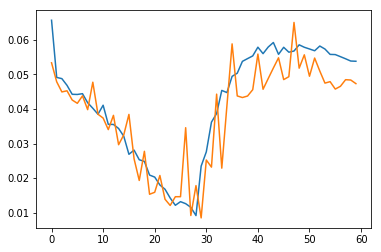

In [262]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

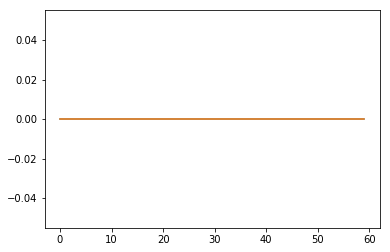

In [263]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

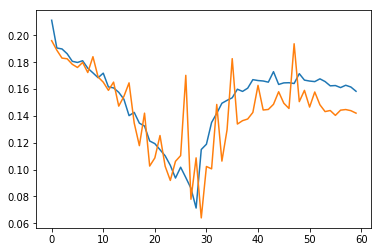

In [264]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [265]:
y_train[:10]

array([ 0.6632602 ,  0.16426798,  0.60676399,  0.66336451,  0.41888738,
        0.05036882,  0.36767579,  0.77754762,  0.10536071,  0.18654477])

In [266]:
f = [0.1, 0.429, 0.856, 1.4]
y = ae.predict(f)
y

array([[ 0.2234183 ],
       [ 0.42795208],
       [ 0.17801178],
       [ 0.18422939]], dtype=float32)

In [267]:
y_train[y_train.argmax()]

0.79896491357161825

In [268]:
y_train[y_train.argmin()]

0.0029234234012234239

m (50, 1)


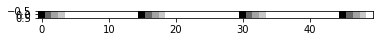

m (50, 1)


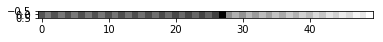

array([ 0.6632602 ,  0.16426798])

In [269]:
f = y_train[:10]
y = decoder_model.predict(f)
plot.single(x_train[0,:50,0])
plot.single(y[0,:50,0])
# plot.single(x_train[1,:50,0])
f[:2]

m (50, 1)


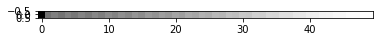

m (50, 1)


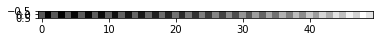

m (50, 1)


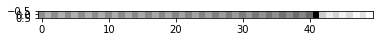

m (50, 1)


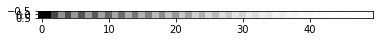

In [270]:
f = [0, 0.3, 0.6, 1.2]
y = decoder_model.predict(f)
plot.single(y[0,:50,0])
plot.single(y[1,:50,0])
plot.single(y[2,:50,0])
plot.single(y[3,:50,0])

m (50, 1)


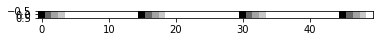

m (50, 1)


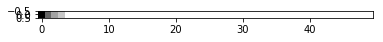

m (50, 1)


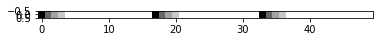

m (50, 1)


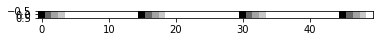

In [238]:
# goal examples
plot.single(x_train[0,:50,0])
plot.single(x_train[1,:50,0])
plot.single(x_train[2,:50,0])
plot.single(x_train[3,:50,0])

In [221]:
y_train[:5]

array([ 0.6632602 ,  0.16426798,  0.60676399,  0.66336451,  0.41888738])